In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from matplotlib.pyplot import imshow
from PIL import Image
# from __future__ import print_function
from sklearn.utils import shuffle
import cv2
import h5py
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
import time

In [2]:
if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('submissions'):
    os.makedirs('submissions')

if not os.path.exists('weights'):
    os.makedirs('weights')

In [3]:
def data_train_extraction(folder_train):
    imagepaths = [x for x in os.walk(folder_train)][0][-1]
    return imagepaths

In [4]:
train_images = data_train_extraction('data/train')

In [5]:
train_images[:10]

['f70aaa64.jpg',
 '35f84fc5.jpg',
 '738fb42a.jpg',
 'd37be89b.jpg',
 '5e001fc8.jpg',
 'a733423a.jpg',
 '0cd6cc7b.jpg',
 '5660bdff.jpg',
 '6833e195.jpg',
 '71177634.jpg']

In [6]:
len(train_images)

9850

In [7]:
test_images = data_train_extraction('data/test')

In [8]:
test_images[:10]

['0540d585.jpg',
 '18b7d686.jpg',
 '112f3797.jpg',
 '678f4374.jpg',
 '4d87a7e6.jpg',
 '3b0e146d.jpg',
 '040c2a16.jpg',
 'f80301ba.jpg',
 'b5514c4d.jpg',
 'ae7383a9.jpg']

In [9]:
len(test_images)

15610

In [2]:
df = pd.read_csv('data/train_ensemble_1.csv')

In [5]:
df.min()

0       7.23408e-25
1       1.18829e-19
10      2.40977e-19
100     1.52415e-19
1000    3.72193e-21
1001    4.86154e-20
1002    1.72457e-15
1003    1.39533e-20
1004     1.2144e-22
1005    1.67695e-20
1006    2.98968e-21
1007     7.8178e-17
1008    1.31949e-18
1009    3.85863e-23
101     1.18887e-21
1010    1.40081e-21
1011    7.45547e-24
1012    3.37846e-22
1013    1.78414e-16
1014     3.4699e-20
1015    3.72192e-17
1016       1.53e-12
1017    1.42563e-20
1018    6.63625e-18
1019    6.07814e-20
102      4.9265e-23
1020    2.96534e-21
1021     1.6271e-19
1022    6.18329e-23
1023    4.50322e-14
           ...     
973      4.2645e-20
974     5.04264e-20
975     5.15001e-23
976     2.14121e-18
977     1.11758e-11
978     5.40322e-23
979     2.76246e-20
98      2.54521e-18
980      6.7418e-19
981      6.3543e-21
982      2.6679e-19
983     1.54916e-20
984     1.32193e-16
985     6.23271e-20
986     6.74374e-20
987     8.56526e-17
988     1.95402e-11
989     1.76669e-18
99      2.03974e-20


In [10]:
ImageToLabelDict = dict(zip( df['Image'], df['Id']))

NameError: name 'df' is not defined

In [11]:
train_images[:4]

['f70aaa64.jpg', '35f84fc5.jpg', '738fb42a.jpg', 'd37be89b.jpg']

In [13]:
# ImageToLabelDict

In [12]:
sorted_image = list()
for img in train_images:
    sorted_image.append(ImageToLabelDict[img])

NameError: name 'ImageToLabelDict' is not defined

In [15]:
df_train = pd.DataFrame({'Image': train_images, 'Id': sorted_image})

In [16]:
df_train[df_train['Image'] == '00087b01.jpg']

,Id,Image
4789,w_da2efe0,00087b01.jpg


In [17]:
df_train = df_train[df_train['Id'] != 'new_whale']

In [18]:
df_train.shape

(9040, 2)

In [13]:
def resize_image(path, resolution):
    img = cv2.imread(path)
    (b, g, r) = cv2.split(img)
    img = cv2.merge([r, g, b])
    image = misc.imresize(img, (resolution, resolution), mode=None)
    return image

def normalize_scale(image_data):
    a = -0.5
    b = 0.5
    scale_min = 0
    scale_max = 255
    return a + (((image_data - scale_min) * (b - a)) / (scale_max - scale_min))

def normalize_images(X_train, X_test, array_test):
    X_normalized = normalize_scale(X_train)
    X_normalized_test = normalize_scale(X_test)
    test_normalized = normalize_scale(array_test)

    return X_normalized, X_normalized_test, test_normalized

def predict_5_better(test_preds_vector):
    most_proba = list()
    maxi_1 = max(test_preds_vector)
    maxi_1_value = np.where(test_preds_vector == maxi_1)[0]
    most_proba.append(int(maxi_1_value))
    siguientes_2 = test_preds_vector[np.where(test_preds_vector != maxi_1)[0]]

    maxi_2 = max(siguientes_2)
    maxi_2_value = np.where(test_preds_vector == maxi_2)[0]
    most_proba.append(int(maxi_2_value))
    siguientes_3 = siguientes_2[np.where(siguientes_2 != maxi_2)[0]]

    maxi_3 = max(siguientes_3)
    maxi_3_value = np.where(test_preds_vector == maxi_3)[0]
    most_proba.append(int(maxi_3_value))
    siguientes_4 = siguientes_3[np.where(siguientes_3 != maxi_3)[0]]

    maxi_4 = max(siguientes_4)
    maxi_4_value = np.where(test_preds_vector == maxi_4)[0]
    most_proba.append(int(maxi_4_value))
    siguientes_5 = siguientes_4[np.where(siguientes_4 != maxi_4)[0]]

    maxi_5 = max(siguientes_5)
    maxi_5_value = np.where(test_preds_vector == maxi_5)[0]
    most_proba.append(int(maxi_5_value))
    
    most_proba = np.array(most_proba)
    
    return most_proba

def predict_4_better(test_preds_vector):
    most_proba = list()
    maxi_1 = max(test_preds_vector)
    maxi_1_value = np.where(test_preds_vector == maxi_1)[0]
    most_proba.append(int(maxi_1_value))
    siguientes_2 = test_preds_vector[np.where(test_preds_vector != maxi_1)[0]]

    maxi_2 = max(siguientes_2)
    maxi_2_value = np.where(test_preds_vector == maxi_2)[0]
    most_proba.append(int(maxi_2_value))
    siguientes_3 = siguientes_2[np.where(siguientes_2 != maxi_2)[0]]

    maxi_3 = max(siguientes_3)
    maxi_3_value = np.where(test_preds_vector == maxi_3)[0]
    most_proba.append(int(maxi_3_value))
    siguientes_4 = siguientes_3[np.where(siguientes_3 != maxi_3)[0]]

    maxi_4 = max(siguientes_4)
    maxi_4_value = np.where(test_preds_vector == maxi_4)[0]
    most_proba.append(int(maxi_4_value[0]))
    
    most_proba = np.array(most_proba)
    
    return most_proba

def submit(name, test_preds):
    with open('submissions/{}.csv'.format(name),'w') as f:
        with warnings.catch_warnings():
            f.write("Image,Id\n")
            warnings.filterwarnings("ignore",category=DeprecationWarning)
            n = 0
            for image in test_images:
                n += 1
                label_arg = predict_4_better(test_preds[n-1])
                preds = label_enconder.inverse_transform(label_arg)
                preds = ['new_whale'] + preds.tolist()
                predicted_tags = " ".join( preds)
                f.write("%s,%s\n" %(image, predicted_tags))
    f.close()

In [14]:
train_img = np.array([resize_image('data/train/'+str(img), 32) for img in df_train['Image']])

NameError: name 'df_train' is not defined

In [22]:
# train_img

In [15]:
X = train_img

NameError: name 'train_img' is not defined

In [20]:
y = df_train['Id']

In [25]:
test_img = np.array([resize_image('data/test/'+str(img), 32) for img in test_images])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

NameError: name 'X' is not defined

In [16]:
X_normalized, X_normalized_test, test_normalized = normalize_images(X, X_test, test_img)

NameError: name 'X' is not defined

In [21]:
label_binarizer = LabelBinarizer()
label_enconder = LabelEncoder()
y_label = label_enconder.fit_transform(y)
y_one_hot = label_binarizer.fit_transform(y_label)
# y_one_hot_test = label_binarizer.fit_transform(y_test)

In [30]:
y_one_hot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
n_output = len(df_train['Id'].unique())

In [35]:
t0 = time.time()

model_name = 'model_whitout_new_whale_32_3'

model = Sequential()
model.add(Convolution2D(16, 4, 4, input_shape=(32, 32, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 4, 4, activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(64, 4, 4, activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(n_output, activation="softmax"))

BATCH_SIZE = 8
EPOCHS = 50
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
gen = ImageDataGenerator(
rotation_range=20,
# featurewise_center=True,
# featurewise_std_normalization=True,
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0,
horizontal_flip=True,
vertical_flip=True
)

earlyStopping = keras.callbacks.EarlyStopping(monitor='acc', patience=5, verbose=1, mode='auto')

model.fit_generator(gen.flow(X_normalized, y_one_hot, batch_size=BATCH_SIZE),
                    steps_per_epoch=250,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[earlyStopping],
                   )


history = model.fit(X_normalized,
y_one_hot,
# steps_per_epoch=100,
epochs=100,
verbose=1,
callbacks=[earlyStopping],
# batch_size=BATCH_SIZE
)

model.save_weights('weights/{}.h5'.format(model_name))
model.save('models/{}.h5'.format(model_name))

print('Training time: {} min'.format(round((time.time()-t0)/60, 4)))

Epoch 1/50
250/250 [==============================] - 4s 16ms/step - loss: 8.3471 - acc: 1.0000e-03
Epoch 2/50
250/250 [==============================] - 3s 11ms/step - loss: 8.3292 - acc: 0.0025
Epoch 3/50
250/250 [==============================] - 3s 11ms/step - loss: 8.3419 - acc: 0.0045
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 8.3694 - acc: 0.0015
Epoch 5/50
250/250 [==============================] - 3s 13ms/step - loss: 8.2278 - acc: 0.0035
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 8.0479 - acc: 0.0035
Epoch 7/50
250/250 [==============================] - 3s 11ms/step - loss: 8.0630 - acc: 0.0035
Epoch 8/50
250/250 [==============================] - 3s 11ms/step - loss: 8.1039 - acc: 0.0030
Epoch 00008: early stopping
Epoch 1/100
9040/9040 [==============================] - 7s 746us/step - loss: 7.9744 - acc: 0.0039
Epoch 2/100
9040/9040 [==============================] - 7s 751us/step - loss: 7.9187 - acc: 0.0040


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [31]:
# model = load_model('models/first_model.h5')
# model.load_weights('weights/first_model.h5')

In [132]:
test_preds = model.predict_proba(test_normalized)

In [133]:
t0 = time.time()
submit('third_submission', test_preds)
print('Submit prediction in: {} secs'.format(round(time.time()-t0),4))

Submit prediction in: 15 secs


Method for sorting faster than np.argsort()

In [111]:
t0 = time.time()

most_proba = list()
pred_prueba = test_preds[0]

maxi_1 = max(pred_prueba)
maxi_1_value = np.where(pred_prueba == maxi_1)[0]
most_proba.append(int(maxi_1_value))
siguientes_2 = test_preds[0][np.where(pred_prueba != maxi_1)[0]]

maxi_2 = max(siguientes_2)
maxi_2_value = np.where(pred_prueba == maxi_2)[0]
most_proba.append(int(maxi_2_value))
siguientes_3 = siguientes_2[np.where(siguientes_2 != maxi_2)[0]]

maxi_3 = max(siguientes_3)
maxi_3_value = np.where(pred_prueba == maxi_3)[0]
most_proba.append(int(maxi_3_value))
siguientes_4 = siguientes_3[np.where(siguientes_3 != maxi_3)[0]]

maxi_4 = max(siguientes_4)
maxi_4_value = np.where(pred_prueba == maxi_4)[0]
most_proba.append(int(maxi_4_value))
siguientes_5 = siguientes_4[np.where(siguientes_4 != maxi_4)[0]]

maxi_5 = max(siguientes_5)
maxi_5_value = np.where(pred_prueba == maxi_5)[0]
most_proba.append(int(maxi_5_value))
# siguientes_5 = siguientes_4[np.where(siguientes_4 != maxi_4)[0]]
print('time elapsed: {} secs'.format(time.time()-t0))
most_proba = np.array(most_proba)
print(most_proba)

time elapsed: 0.002024412155151367 secs
[ 266 1488 1716 1861  286]


In [112]:
t0 = time.time()
np.argsort(test_preds)[0][::-1][:5]
print('time elapsed: {} secs'.format(time.time()-t0))

time elapsed: 3.4980714321136475 secs


\>> 1000 time faster

In [113]:
vec = predict_5_better(test_preds[0])
vec

array([ 266, 1488, 1716, 1861,  286])

In [114]:
vec = predict_4_better(test_preds[0])
vec

[1488]


array([ 266, 1488, 1716, 1861])

New models with image shape (56, 56)

In [18]:
train_img = np.array([resize_image('data/train/'+str(img), 56) for img in df_train['Image']])

NameError: name 'df_train' is not defined

In [19]:
X = train_img

NameError: name 'train_img' is not defined

In [23]:
y = df_train['Id']

In [49]:
test_img = np.array([resize_image('data/test/'+str(img), 56) for img in test_images])

In [102]:
X_normalized, X_normalized_test, test_normalized = normalize_images(X, X, test_img)

NameError: name 'X' is not defined

In [26]:
label_binarizer = LabelBinarizer()
label_enconder = LabelEncoder()
y_label = label_enconder.fit_transform(y)
y_one_hot = label_binarizer.fit_transform(y_label)

In [50]:
np.savez('data/array_data/X_train_200', X)
np.savez('data/array_data/X_test_200', test_img)

In [21]:
X_train = np.load('data/array_data/X_train_56.npz')['arr_0']

In [22]:
X_test = np.load('data/array_data/X_test_56.npz')['arr_0']

In [37]:
X_normalized, X_normalized_test, test_normalized = normalize_images(X_train, X_train, X_train)

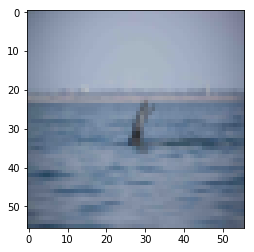

In [93]:
plt.imshow(X_train[900])

In [94]:
laplacian = cv2.Laplacian(X_train[900],cv2.CV_64F)

In [95]:
blurred = cv2.GaussianBlur(X_train[900], (5, 5), 0)

In [96]:
fgbg = cv2.createBackgroundSubtractorMOG2()
fgmask = fgbg.apply(X_train[900])

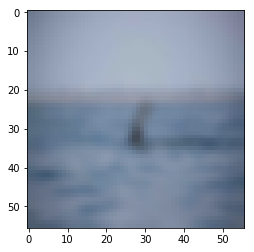

In [100]:
plt.imshow(blurred)

In [153]:
ret,thresh1 = cv2.threshold(X_train[100],127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(X_train[1000],127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(X_train[1000],127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(X_train[1000],100,200,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(X_train[1000],127,255,cv2.THRESH_TOZERO_INV)

In [181]:
X_grey = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in X_train]

In [194]:
X_grey = np.array(X_grey)

In [195]:
X_normalized_grey, X_normalized_test, test_normalized = normalize_images(X_grey, X_grey, X_grey)

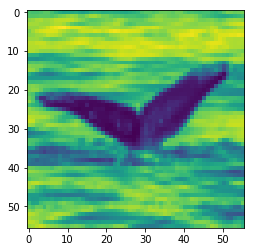

In [198]:
plt.imshow(X_grey[1000])

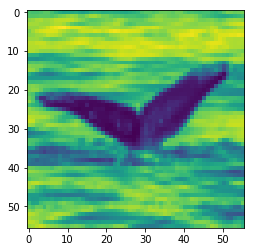

In [199]:
plt.imshow(X_normalized_grey[1000])

In [205]:
len(X_grey[0])

56

In [27]:
model_load = load_model('models/model_whitout_new_whale_56_2.h5')
model_load.load_weights('weights/model_whitout_new_whale_56_2.h5')

In [28]:
test_preds = model_load.predict_proba(test_normalized)

In [29]:
# for i in test_preds:
#     print(max(i))

In [63]:
def predict_new_5_better(test_preds_vector, thr = 0.5):
    most_proba = list()
    maxi_1 = max(test_preds_vector)
    if maxi_1 < thr:
        most_proba.append('new_whale')
    else:
        maxi_1_value = np.where(test_preds_vector == maxi_1)[0]
        most_proba.append(int(maxi_1_value))
    siguientes_2 = test_preds_vector[np.where(test_preds_vector != maxi_1)[0]]

    maxi_2 = max(siguientes_2)
    maxi_2_value = np.where(test_preds_vector == maxi_2)[0]
    most_proba.append(int(maxi_2_value))
    siguientes_3 = siguientes_2[np.where(siguientes_2 != maxi_2)[0]]

    maxi_3 = max(siguientes_3)
    maxi_3_value = np.where(test_preds_vector == maxi_3)[0]
    most_proba.append(int(maxi_3_value))
    siguientes_4 = siguientes_3[np.where(siguientes_3 != maxi_3)[0]]

    maxi_4 = max(siguientes_4)
    maxi_4_value = np.where(test_preds_vector == maxi_4)[0]
    most_proba.append(int(maxi_4_value[0]))
    siguientes_5 = siguientes_4[np.where(siguientes_4 != maxi_4)[0]]

    maxi_5 = max(siguientes_5)
    maxi_5_value = np.where(test_preds_vector == maxi_5)[0]
    most_proba.append(int(maxi_5_value))
    
    most_proba = np.array(most_proba)
    
    return most_proba

def new_submit(name, test_preds, thr = 0.5):
    with open('submissions/{}.csv'.format(name),'w') as f:
        with warnings.catch_warnings():
            f.write("Image,Id\n")
            warnings.filterwarnings("ignore",category=DeprecationWarning)
            n = 0
            for image in test_images:
                n += 1
                label_arg = predict_new_5_better(test_preds[n-1], thr)
                if label_arg[0] == 'new_whale':
                    preds = label_enconder.inverse_transform(list(map(int, label_arg[1:])))
                    preds = ['new_whale'] + preds.tolist()
                else:
                    preds = label_enconder.inverse_transform(label_arg)
                predicted_tags = " ".join( preds)
                f.write("%s,%s\n" %(image, predicted_tags))
    f.close()

In [37]:
t0 = time.time()
new_submit('submission_56_thr_09', test_preds, 0.9)
print('Submit prediction in: {} secs'.format(round(time.time()-t0,1)))

Submit prediction in: 18.0 secs


In [45]:
n_output = len(df_train['Id'].unique())

In [47]:
t0 = time.time()
n_output = len(df_train['Id'].unique())

model_name = 'model_whitout_new_whale_56_3'

model = Sequential()
model.add(Convolution2D(4, 3, 3, input_shape=(56, 56, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(8, 4, 4, activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(16, 2, 2, activation="sigmoid"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(n_output, activation="softmax"))

BATCH_SIZE = 8
EPOCHS = 50
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
# gen = ImageDataGenerator(
# rotation_range=20,
# # featurewise_center=True,
# # featurewise_std_normalization=True,
# width_shift_range=0.2,
# height_shift_range=0.2,
# zoom_range=0,
# # horizontal_flip=True,
# # vertical_flip=True
# )

earlyStopping = keras.callbacks.EarlyStopping(monitor='acc', patience=5, verbose=1, mode='auto')

# model.fit_generator(gen.flow(X_normalized, y_one_hot, batch_size=BATCH_SIZE),
#                     steps_per_epoch=250,
#                     epochs=EPOCHS,
#                     verbose=1,
#                     callbacks=[earlyStopping],
#                    )


history = model.fit(X_normalized,
y_one_hot,
# steps_per_epoch=100,
epochs=70,
verbose=1,
callbacks=[earlyStopping],
# batch_size=BATCH_SIZE
)

model.save_weights('weights/{}.h5'.format(model_name))
model.save('models/{}.h5'.format(model_name))

print('Training time: {} min'.format(round((time.time()-t0)/60, 4)))

Epoch 1/70
9040/9040 [==============================] - 12s 1ms/step - loss: 8.6597 - acc: 0.0030
Epoch 2/70
9040/9040 [==============================] - 11s 1ms/step - loss: 8.2354 - acc: 0.0038
Epoch 3/70
9040/9040 [==============================] - 11s 1ms/step - loss: 8.0950 - acc: 0.0058
Epoch 4/70
9040/9040 [==============================] - 11s 1ms/step - loss: 7.8747 - acc: 0.0074
Epoch 5/70
9040/9040 [==============================] - 11s 1ms/step - loss: 7.4692 - acc: 0.0118
Epoch 6/70
9040/9040 [==============================] - 11s 1ms/step - loss: 6.7845 - acc: 0.0358
Epoch 7/70
9040/9040 [==============================] - 11s 1ms/step - loss: 5.8359 - acc: 0.0924
Epoch 8/70
9040/9040 [==============================] - 11s 1ms/step - loss: 4.9429 - acc: 0.1980
Epoch 9/70
9040/9040 [==============================] - 11s 1ms/step - loss: 4.2326 - acc: 0.3023
Epoch 10/70
9040/9040 [==============================] - 11s 1ms/step - loss: 3.6788 - acc: 0.3897
Epoch 11/70
9040/90

In [48]:
test_preds = model.predict_proba(test_normalized)

In [57]:
test_preds[5].max()

0.9999411

submission

In [62]:
t0 = time.time()
submit('third_submission_56', test_preds)
print('Submit prediction in: {} secs'.format(round(time.time()-t0),4))

Submit prediction in: 15 secs


with threshold

In [64]:
t0 = time.time()
new_submit('submission_56_3_thr_095', test_preds, 0.95)
print('Submit prediction in: {} secs'.format(round(time.time()-t0,1)))

Submit prediction in: 19.2 secs


New models with image shape (128, 128)

In [55]:
train_img = np.array([resize_image('data/train/'+str(img), 128) for img in df_train['Image']])

In [56]:
# train_img

In [57]:
X = train_img

In [58]:
y = df_train['Id']

In [59]:
test_img = np.array([resize_image('data/test/'+str(img), 128) for img in test_images])

In [60]:
X_normalized, X_normalized_test, test_normalized = normalize_images(X, X_test, test_img)

In [61]:
label_binarizer = LabelBinarizer()
label_enconder = LabelEncoder()
y_label = label_enconder.fit_transform(y)
y_one_hot = label_binarizer.fit_transform(y_label)

In [62]:
n_output = len(df_train['Id'].unique())

In [65]:
t0 = time.time()

model_name = 'model_whitout_new_whale_128_1'

model = Sequential()
model.add(Convolution2D(16, 4, 4, input_shape=(128, 128, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 4, 4, activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
# model.add(Convolution2D(256, 4, 4, activation="relu"))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(n_output, activation="softmax"))

BATCH_SIZE = 8
EPOCHS = 50
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
# gen = ImageDataGenerator(
# rotation_range=20,
# # featurewise_center=True,
# # featurewise_std_normalization=True,
# width_shift_range=0.2,
# height_shift_range=0.2,
# zoom_range=0,
# # horizontal_flip=True,
# # vertical_flip=True
# )

earlyStopping = keras.callbacks.EarlyStopping(monitor='acc', patience=5, verbose=1, mode='auto')

# model.fit_generator(gen.flow(X_normalized, y_one_hot, batch_size=BATCH_SIZE),
#                     steps_per_epoch=250,
#                     epochs=EPOCHS,
#                     verbose=1,
#                     callbacks=[earlyStopping],
#                    )


history = model.fit(X_normalized,
y_one_hot,
# steps_per_epoch=100,
epochs=100,
verbose=1,
callbacks=[earlyStopping],
# batch_size=BATCH_SIZE
)

model.save_weights('weights/{}.h5'.format(model_name))
model.save('models/{}.h5'.format(model_name))

print('Training time: {} min'.format(round((time.time()-t0)/60, 4)))

Epoch 1/100
9040/9040 [==============================] - 71s 8ms/step - loss: 8.3327 - acc: 0.0019
Epoch 2/100
9040/9040 [==============================] - 71s 8ms/step - loss: 8.0584 - acc: 0.0038
Epoch 3/100
9040/9040 [==============================] - 71s 8ms/step - loss: 7.8103 - acc: 0.0064
Epoch 4/100
9040/9040 [==============================] - 70s 8ms/step - loss: 7.3931 - acc: 0.0108
Epoch 5/100
9040/9040 [==============================] - 70s 8ms/step - loss: 6.8167 - acc: 0.0283
Epoch 6/100
9040/9040 [==============================] - 70s 8ms/step - loss: 6.0914 - acc: 0.0592
Epoch 7/100
9040/9040 [==============================] - 71s 8ms/step - loss: 5.2805 - acc: 0.1127
Epoch 8/100
9040/9040 [==============================] - 71s 8ms/step - loss: 4.5191 - acc: 0.1765
Epoch 9/100
9040/9040 [==============================] - 71s 8ms/step - loss: 3.8439 - acc: 0.2580
Epoch 10/100
9040/9040 [==============================] - 71s 8ms/step - loss: 3.3133 - acc: 0.3240
Epoch 11/

In [66]:
test_preds = model.predict_proba(test_normalized)

In [67]:
t0 = time.time()
submit('first_submission_128', test_preds)
print('Submit prediction in: {} secs'.format(round(time.time()-t0),4))

Submit prediction in: 16 secs


In [2]:
label_encoder = LabelEncoder()
label_binarizer = LabelBinarizer()

In [3]:
train = pd.read_csv('data/train_ensemble_1.csv')
X = train.loc[:, train.columns != 'Id']
n_cols = len(X.columns)
y = train['Id']

# Label encoder y one hot. Necessary for keras models
y_label = label_encoder.fit_transform(y)
y_one_hot = label_binarizer.fit_transform(y_label)

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

In [49]:
euc_dist = euclidean_distances(X, X.iloc[0,:])

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [38]:
# euc_dist[euc_dist == euc_dist.min()]
np.where(euc_dist == euc_dist.min())

(array([0]), array([0]))

In [56]:
euc_dist[9039]

array([12.77837426])

'w_9d704ab'

In [65]:
pred = X.iloc[0,:]
euc_dist = euclidean_distances(X, pred)
most_proba = list()
maxi_1 = min(euc_dist)
maxi_1_value = np.where(euc_dist == maxi_1)[0]
most_proba.append(y[int(maxi_1_value[0])])
siguientes_2 = euc_dist[np.where(euc_dist != maxi_1)[0]]

maxi_2 = min(siguientes_2)
maxi_2_value = np.where(euc_dist == maxi_2)[0]
most_proba.append(y[int(maxi_2_value[0])])
siguientes_3 = siguientes_2[np.where(siguientes_2 != maxi_2)[0]]

maxi_3 = min(siguientes_3)
maxi_3_value = np.where(euc_dist == maxi_3)[0]
most_proba.append(y[int(maxi_3_value[0])])
siguientes_4 = siguientes_3[np.where(siguientes_3 != maxi_3)[0]]

# maxi_4 = min(siguientes_4)
# maxi_4_value = np.where(euc_dist == maxi_4)[0]
# most_proba.append(y[int(maxi_4_value[0])])

most_proba = np.array(most_proba)
most_proba = ['new_whale'] + most_proba.tolist()

print(most_proba)
predicted_tags = " ".join(most_proba)
print(predicted_tags)

['new_whale', 'w_9d704ab', 'w_9d704ab', 'w_9d704ab']
new_whale w_9d704ab w_9d704ab w_9d704ab


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [25]:
euc_dist[0]

array([ 0.        ,  0.96867356,  0.96867356, ..., 16.5515881 ,
       16.5515881 , 16.55171293])